In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import StandardScaler
import xgboost as xgb

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# read in the Kessler Objects of Interest (KOI) dataset
# the first 53 lines are description
df = pd.read_csv('../data/koi.csv', skiprows=53)
df.head()

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_tce_plnt_num,koi_tce_delivname,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,615.8,19.5,-19.5,2.26,0.26,-0.15,793.0,NaN,NaN,93.59,29.45,-16.65,35.8,1.0,q1_q17_dr25_tce,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,874.8,35.5,-35.5,2.83,0.32,-0.19,443.0,NaN,NaN,9.11,2.87,-1.62,25.8,2.0,q1_q17_dr25_tce,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10829.0,171.0,-171.0,14.60,3.92,-1.31,638.0,NaN,NaN,39.30,31.04,-10.49,76.3,1.0,q1_q17_dr25_tce,5853.0,158.0,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8079.2,12.8,-12.8,33.46,8.50,-2.83,1395.0,NaN,NaN,891.96,668.95,-230.35,505.6,1.0,q1_q17_dr25_tce,5805.0,157.0,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,603.3,16.9,-16.9,2.75,0.88,-0.35,1406.0,NaN,NaN,926.16,874.33,-314.24,40.9,1.0,q1_q17_dr25_tce,6031.0,169.0,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


Making an assumption here that "CANDIDATE" doesn't tell us very much.
We want to train a model to predict whether a row will be "CONFIRMED" or a "FALSE POSITIVE"

In [3]:
# remove the "CANDIDATE" rows
df = df[df['koi_disposition'] != 'CANDIDATE']

We want to try and use the information we have about the exoplanet to predict the **koi_pdisposition** field.

In [4]:
# these are the columns we are interested in using
X = df[['koi_period', 'koi_time0bk', 'koi_impact', 'koi_duration', 'koi_depth', 'koi_prad', 'koi_teq', 'koi_insol', 'koi_model_snr', 'koi_steff', 'koi_slogg', 'koi_srad', 'koi_kepmag']]

# replace missing values with the mean of the column
X = X.fillna(X.mean())

# we want to predict if the disposition is CONFIRMED
y = df['koi_disposition'] == 'CONFIRMED'

# remove outliers
mask = (np.abs(stats.zscore(X)) < 3).all(axis=1)

X = X[mask]
y = y[mask]

print(X)

      koi_period  koi_time0bk  koi_impact  ...  koi_slogg  koi_srad  koi_kepmag
0       9.488036   170.538750       0.146  ...      4.467     0.927      15.347
1      54.418383   162.513840       0.586  ...      4.467     0.927      15.347
3       1.736952   170.307565       1.276  ...      4.564     0.791      15.597
4       2.525592   171.595550       0.701  ...      4.438     1.046      15.509
5      11.094321   171.201160       0.538  ...      4.486     0.972      15.714
...          ...          ...         ...  ...        ...       ...         ...
9554  330.808790   281.156800       0.920  ...      4.382     1.066      11.976
9558    8.589871   132.016100       0.765  ...      4.296     1.088      14.478
9559    0.527699   131.705093       1.252  ...      4.529     0.903      14.082
9561    0.681402   132.181750       0.147  ...      4.447     1.041      15.385
9563    4.856035   135.993300       0.134  ...      4.385     1.193      14.826

[6345 rows x 13 columns]


## Understanding the data

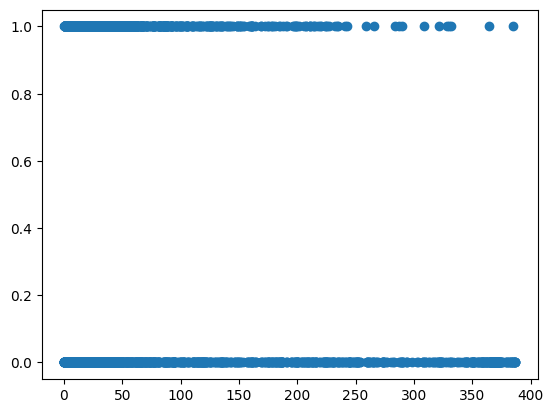

In [5]:
plt.scatter(X['koi_period'], y)


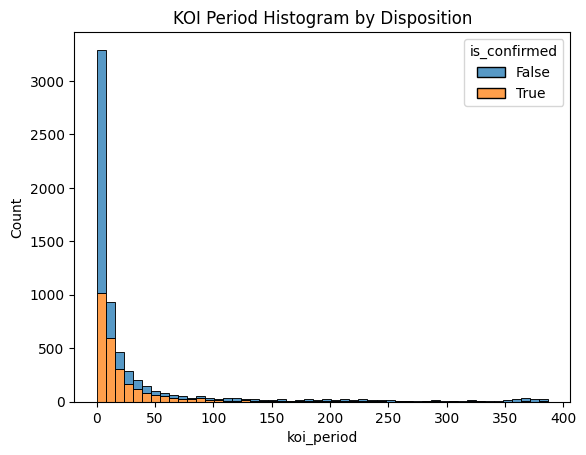

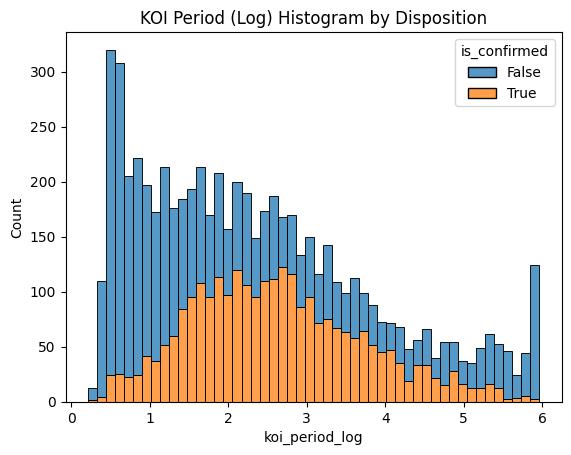

3.22354988550932
0.6804872606123449


In [6]:
# DANGER - re-using df
df = X.copy()
df['is_confirmed'] = y

sns.histplot(data=df, x='koi_period', hue='is_confirmed', bins=50, kde=False, multiple='stack')
plt.xlabel('koi_period')
plt.title('KOI Period Histogram by Disposition')
plt.show()

df['koi_period_log'] = np.log1p(df['koi_period'])

sns.histplot(data=df, x='koi_period_log', hue='is_confirmed', bins=50, kde=False, multiple='stack')
plt.xlabel('koi_period_log')
plt.title('KOI Period (Log) Histogram by Disposition')
plt.show()


print(df['koi_period'].skew())
print(df['koi_period_log'].skew())


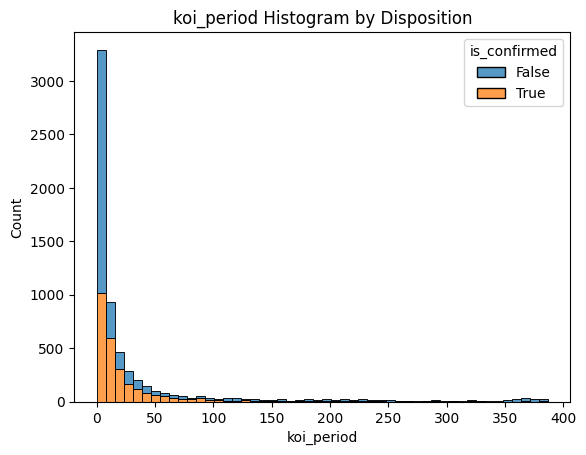

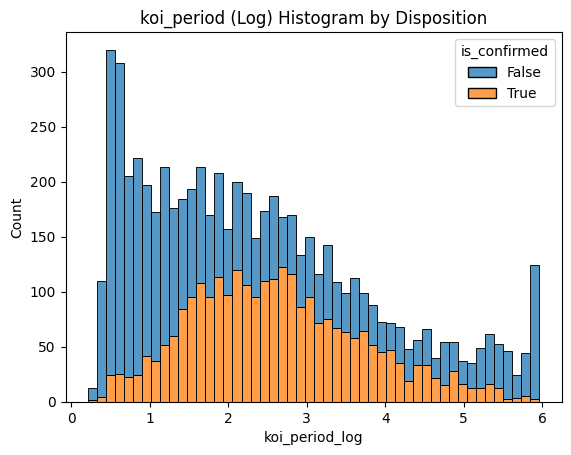

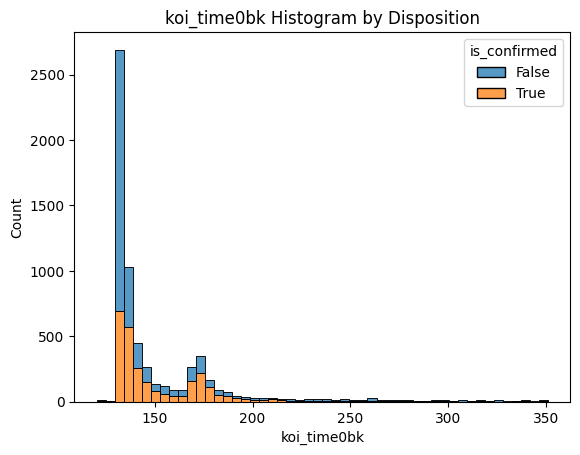

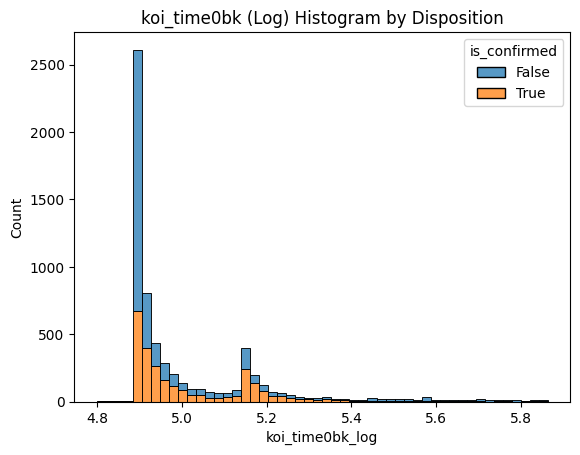

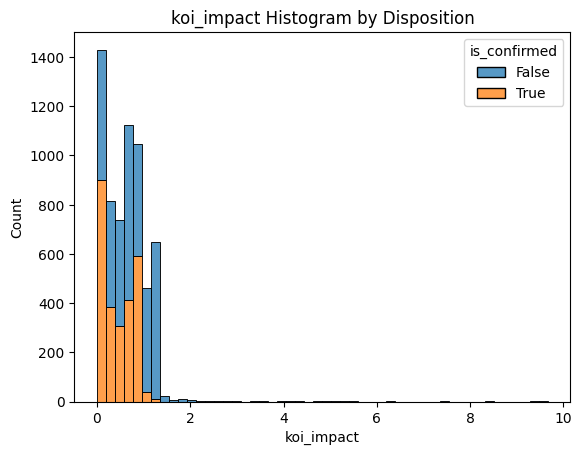

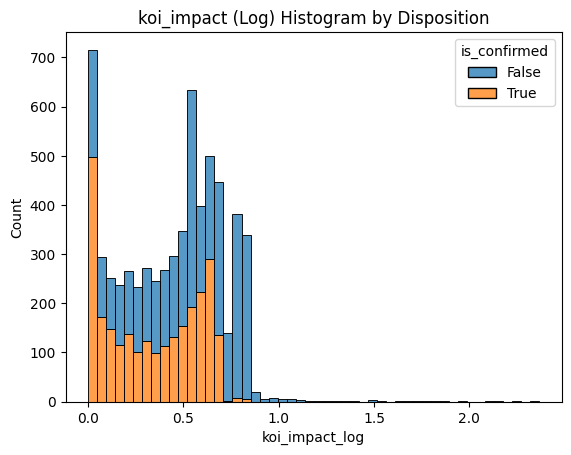

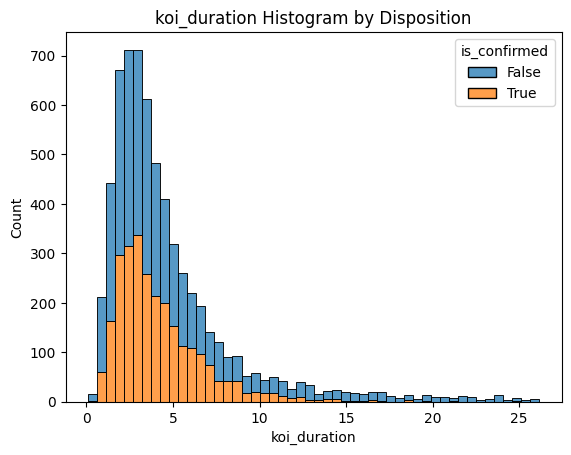

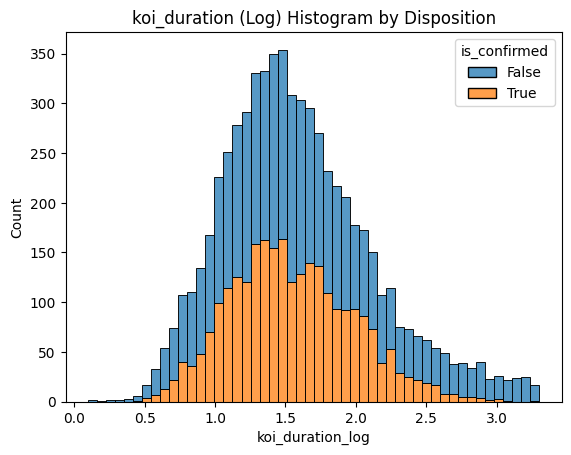

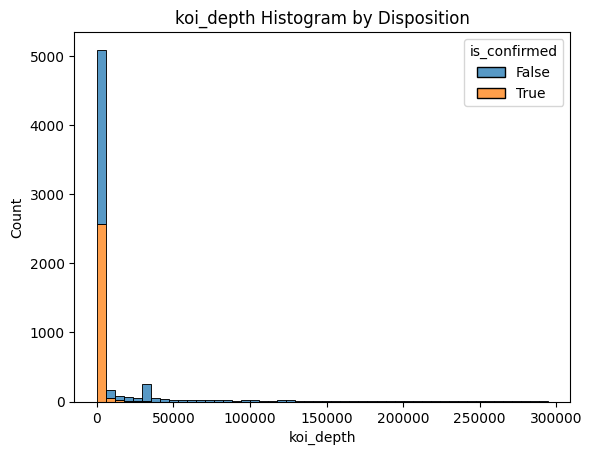

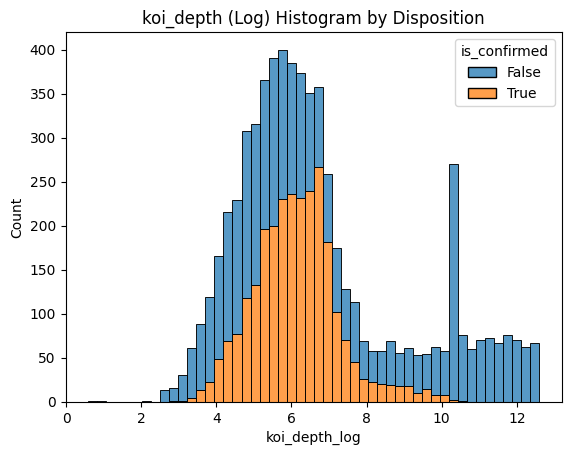

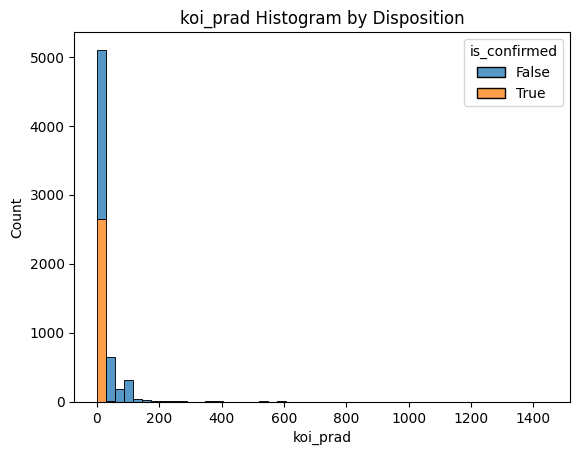

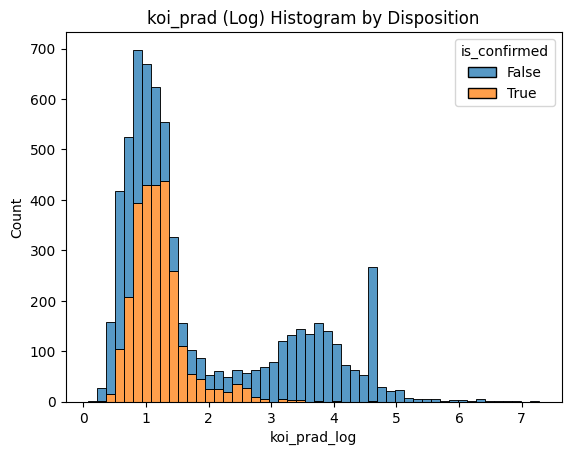

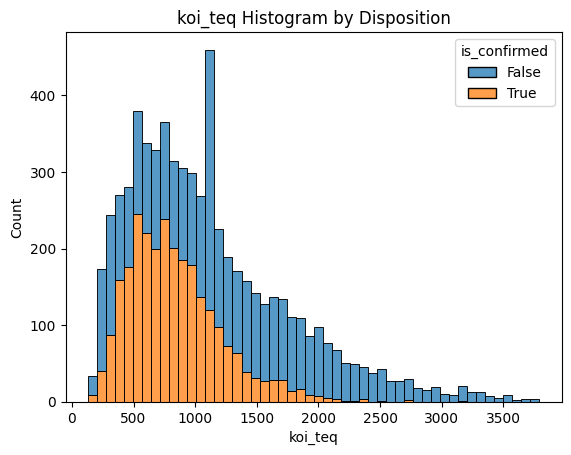

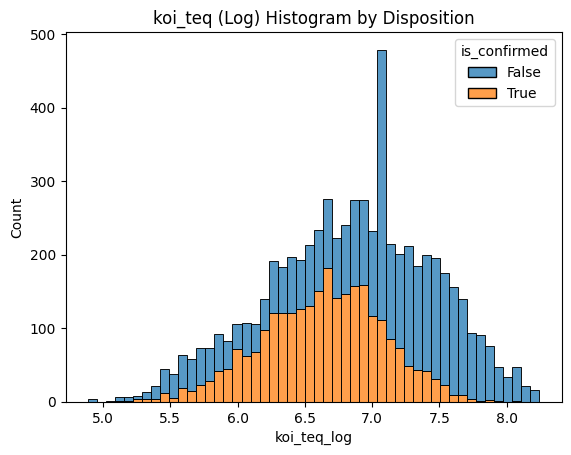

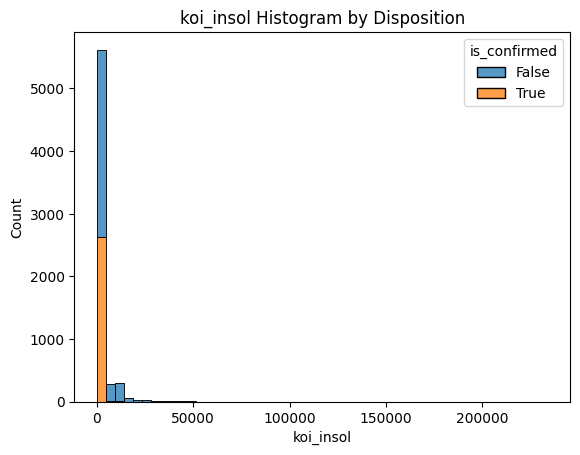

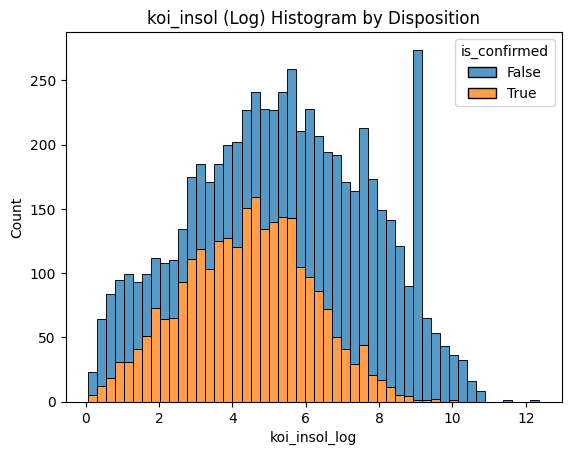

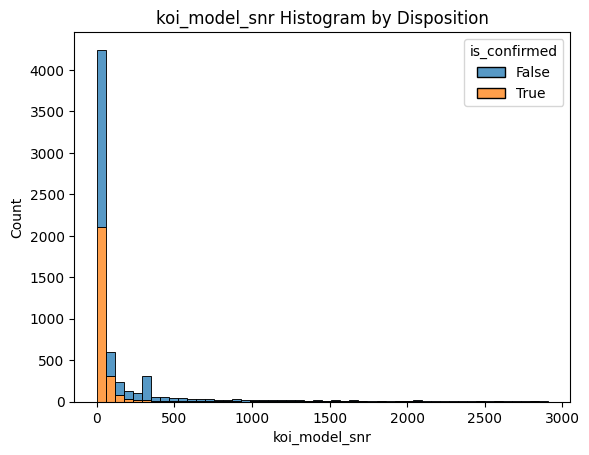

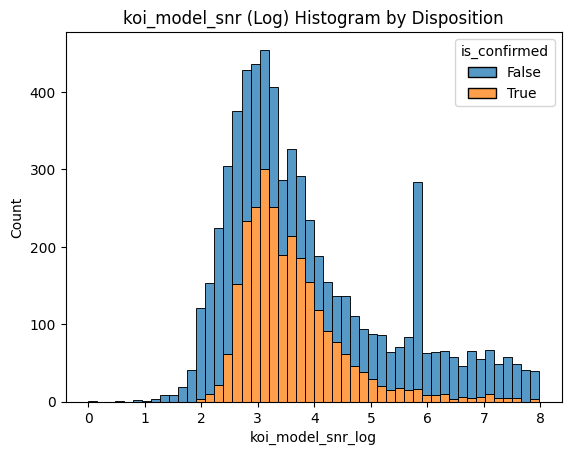

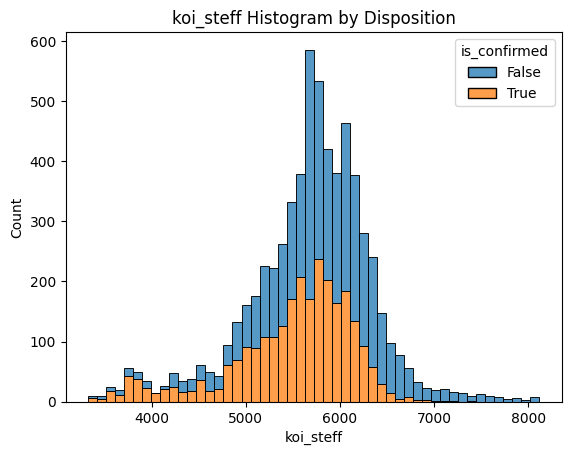

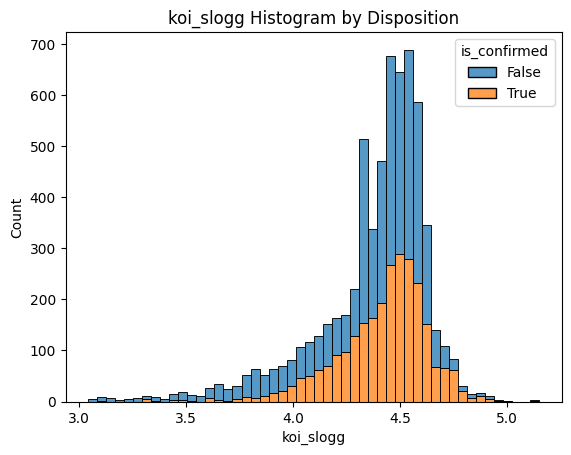

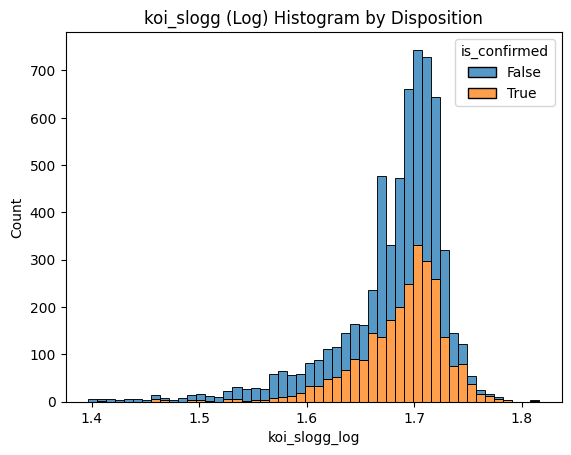

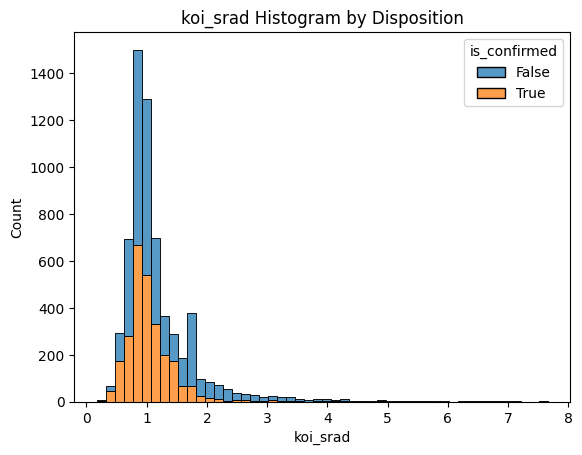

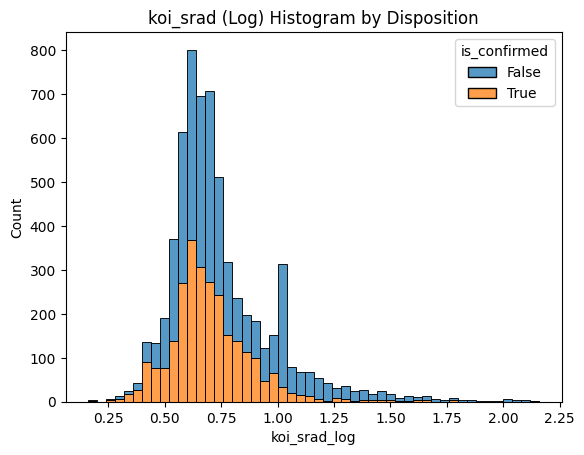

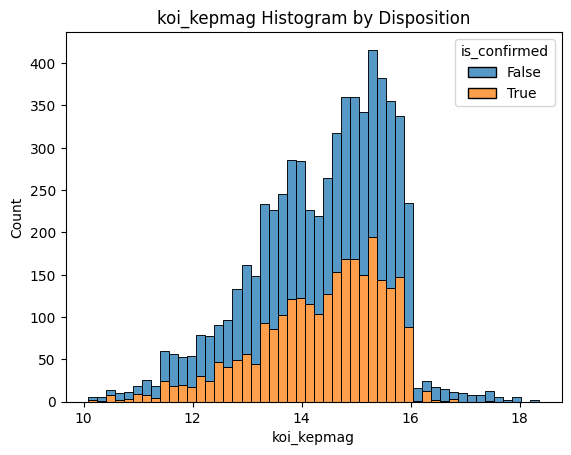

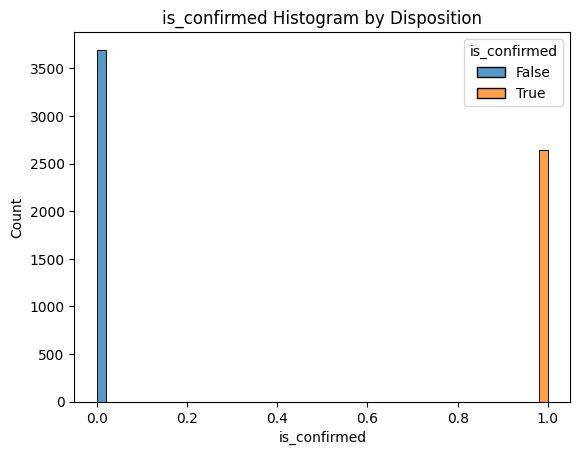

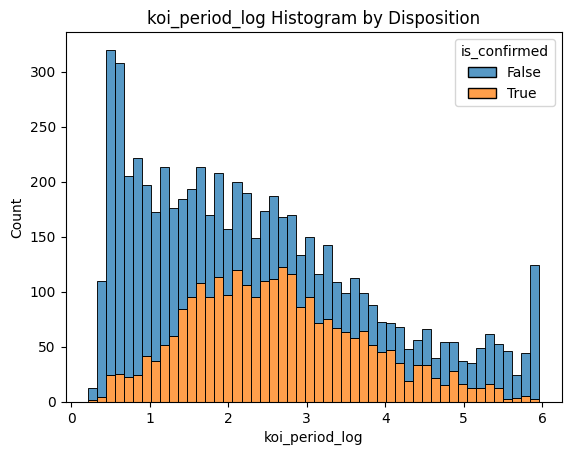

In [7]:
# Let's look at all our columns
for column in df.columns:
    sns.histplot(data=df, x=column, hue='is_confirmed', bins=50, kde=False, multiple='stack')
    plt.xlabel(column)
    plt.title(f'{column} Histogram by Disposition')
    plt.show()

    if (abs(df[column].skew()) > 1):
        df[f'{column}_log'] = np.log1p(df[column])
        sns.histplot(data=df, x=f'{column}_log', hue='is_confirmed', bins=50, kde=False, multiple='stack')
        plt.xlabel(f'{column}_log')
        plt.title(f'{column} (Log) Histogram by Disposition')
        plt.show()

Feature Engineering

In [8]:
# logify the koi_period column
# TODO make this a separate column or at least remember I transformed it
# NOTE - the model performed worse with this transformation

# most of our features are skewed, so we add a log transform column of each
for column in X.columns:
    X[column + '_log'] = np.log1p(X[column])

scaler = StandardScaler()

X_pre_scaling = X.copy()

feature_names = X.columns
X = scaler.fit_transform(X)

In [9]:
# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Linear Regression

In [10]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test) > 0.5
lr_accuracy = accuracy_score(y_test, y_pred)
print(f'Linear Regression accuracy: {100 * lr_accuracy:.2f}%')


Linear Regression accuracy: 85.24%


## Linear Regression with Polynomial Features

In [11]:
poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train)

lr_wp_model = LinearRegression()
lr_wp_model.fit(X_train_poly, y_train)

X_test_poly = poly_features.transform(X_test)
y_pred = lr_wp_model.predict(X_test_poly) >= 0.5
lr_wp_accuracy = accuracy_score(y_test, y_pred)
print(f'Linear Regression with Polynomial Features accuracy: {100 * lr_wp_accuracy:.2f}%')

Linear Regression with Polynomial Features accuracy: 90.55%


## XGBoost

In [12]:
xgb_model = xgb.XGBClassifier(eval_metric='logloss')
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, y_pred)
print(f'XGBoost accuracy: {100 * xgb_accuracy:.2f}%')


XGBoost accuracy: 92.49%


## XGBoost with Polynomial Features

In [13]:
xgb_model_poly = xgb.XGBClassifier(eval_metric='logloss')
xgb_model_poly.fit(X_train_poly, y_train)

y_pred = xgb_model_poly.predict(X_test_poly)
xgb_wp_accuracy = accuracy_score(y_test, y_pred)
print(f'XGBoost accuracy: {100 * xgb_wp_accuracy:.2f}%')

XGBoost accuracy: 92.44%


## Neural Network

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

nn_model = keras.Sequential([
    layers.Dense(250, activation='relu', input_shape=(X_train_poly.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

nn_model.fit(X_train_poly, y_train, epochs=100, validation_split=0.2)
nn_loss, nn_accuracy = nn_model.evaluate(X_test_poly, y_test)
print(f"TensorFlow Neural Network accuracy: {100 * nn_accuracy:.2f}%")

c:\Users\russp\source\repos\nasa-space-apps-exoplanets\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8404 - loss: 0.3833 - val_accuracy: 0.9100 - val_loss: 0.2459
Epoch 2/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8925 - loss: 0.2703 - val_accuracy: 0.9134 - val_loss: 0.2230
Epoch 3/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8961 - loss: 0.2443 - val_accuracy: 0.9134 - val_loss: 0.2433
Epoch 4/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9051 - loss: 0.2314 - val_accuracy: 0.8999 - val_loss: 0.2504
Epoch 5/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9060 - loss: 0.2310 - val_accuracy: 0.9010 - val_loss: 0.2337
Epoch 6/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8995 - loss: 0.2399 - val_accuracy: 0.8301 - val_loss: 0.5043
Epoch 7/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8981 - loss: 0.2305 - val_accuracy: 0.9044 - val_loss: 0.2589
Epoch 8/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9051 - loss: 0.2176 - val_acc

In [15]:
def display_percentage(x):
    return f"{100 * x:.2f}%"

pd.DataFrame([
    ["LinearRegression:", display_percentage(lr_accuracy)],
    ["LinearRegression with Polynomial Features:", display_percentage(lr_wp_accuracy)],
    ["XGBoost:", display_percentage(xgb_accuracy)],
    ["XGBoost with Polynomial Features:", display_percentage(xgb_wp_accuracy)],
    ["Neural Network:", display_percentage(nn_accuracy)]
])

,0,1
0,LinearRegression:,85.24%
1,LinearRegression with Polynomial Features:,90.55%
2,XGBoost:,92.49%
3,XGBoost with Polynomial Features:,92.44%
4,Neural Network:,89.92%


XGBoost seems to perform really well on our data. Let's explore which features it found to be the most important

In [16]:
importances = xgb_model.feature_importances_

# Display as a DataFrame
pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False)

,feature,importance
5,koi_prad,0.234977
7,koi_insol,0.158990
8,koi_model_snr,0.121643
0,koi_period,0.115942
13,koi_period_log,0.062070
3,koi_duration,0.057206
2,koi_impact,0.044024
6,koi_teq,0.038899
9,koi_steff,0.033162
4,koi_depth,0.031046


XGBoost doesn't work well with highly correlated features. Adding the log features may not have helped.
Let's try to optimise specifically for XGBoost

In [17]:
selected_features = ['koi_period_log', 'koi_duration_log', 'koi_depth_log', 'koi_prad_log', 'koi_teq_log', 'koi_insol_log', 'koi_model_snr_log', 'koi_steff_log', 'koi_slogg_log', 'koi_srad_log']
engineered_X = X_pre_scaling[selected_features]

# TODO add missing features

# Adding interaction terms did not improve the model
#poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
#engineered_X = poly.fit_transform(engineered_X)

#all_feature_names = poly.get_feature_names_out(selected_features)

X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(engineered_X, y, test_size=0.3, random_state=42)

xgb_model = xgb.XGBClassifier(eval_metric='logloss')
xgb_model.fit(X_train_eng, y_train_eng)

y_pred = xgb_model.predict(X_test_eng)
xgb_accuracy = accuracy_score(y_test_eng, y_pred)
print(f'XGBoost (with feature engineering) accuracy: {100 * xgb_accuracy:.2f}%')

XGBoost (with feature engineering) accuracy: 91.65%


In [18]:
importances = xgb_model.feature_importances_

# Display as a DataFrame
pd.DataFrame({'feature': selected_features, 'importance': importances}).sort_values('importance', ascending=False)

,feature,importance
3,koi_prad_log,0.254394
5,koi_insol_log,0.206944
6,koi_model_snr_log,0.132346
0,koi_period_log,0.121531
1,koi_duration_log,0.076729
4,koi_teq_log,0.045513
9,koi_srad_log,0.044699
8,koi_slogg_log,0.044435
7,koi_steff_log,0.043617
2,koi_depth_log,0.029794


In [19]:
# let's save the xgboost model for later use
xgb_model.save_model('../models/xgb_koi_model.json')

In [20]:
df


,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_insol,koi_model_snr,koi_steff,koi_slogg,koi_srad,koi_kepmag,is_confirmed,koi_period_log,koi_time0bk_log,koi_impact_log,koi_duration_log,koi_depth_log,koi_prad_log,koi_teq_log,koi_insol_log,koi_model_snr_log,koi_slogg_log,koi_srad_log
0,9.488036,170.538750,0.146,2.95750,615.8,2.26,793.0,93.59,35.8,5455.0,4.467,0.927,15.347,True,2.350235,5.144809,0.136278,1.375613,6.424545,1.181727,6.677083,4.549552,3.605498,1.698730,0.655964
1,54.418383,162.513840,0.586,4.50700,874.8,2.83,443.0,9.11,25.8,5455.0,4.467,0.927,15.347,True,4.014911,5.096898,0.461215,1.706020,6.775138,1.342865,6.095825,2.313525,3.288402,1.698730,0.655964
3,1.736952,170.307565,1.276,2.40641,8079.2,33.46,1395.0,891.96,505.6,5805.0,4.564,0.791,15.597,False,1.006845,5.143461,0.822420,1.225659,8.997172,3.539799,7.241366,6.794542,6.227722,1.716317,0.582774
4,2.525592,171.595550,0.701,1.65450,603.3,2.75,1406.0,926.16,40.9,6031.0,4.438,1.046,15.509,True,1.260048,5.150951,0.531216,0.976256,6.404071,1.321756,7.249215,6.832126,3.735286,1.693411,0.715887
5,11.094321,171.201160,0.538,4.59450,1517.5,3.90,835.0,114.81,66.5,6046.0,4.486,0.972,15.714,True,2.492736,5.148663,0.430483,1.721784,7.325478,1.589235,6.728629,4.751951,4.212128,1.702199,0.679048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9554,330.808790,281.156800,0.920,21.66900,274.8,2.13,290.0,1.67,24.4,6158.0,4.382,1.066,11.976,False,5.804559,5.642463,0.652325,3.120998,5.619676,1.141033,5.673323,0.982078,3.234749,1.683060,0.725614
9558,8.589871,132.016100,0.765,4.80600,87.7,1.11,929.0,176.40,8.4,5638.0,4.296,1.088,14.478,False,2.260707,4.890470,0.568151,1.758892,4.485260,0.746688,6.835185,5.178407,2.240710,1.666952,0.736207
9559,0.527699,131.705093,1.252,3.22210,1579.2,29.35,2088.0,4500.53,453.3,5638.0,4.529,0.903,14.082,False,0.423762,4.888129,0.811819,1.440333,7.365307,3.412797,7.644441,8.412173,6.118758,1.710007,0.643432
9561,0.681402,132.181750,0.147,0.86500,103.6,1.07,2218.0,5713.41,12.3,6173.0,4.447,1.041,15.385,False,0.519628,4.891715,0.137150,0.623261,4.650144,0.727549,7.704812,8.650746,2.587764,1.695065,0.713440
